In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import VR_Model, optimize_lags
from sdice_model import SimplifiedDICE, ScenarioDICE
from portfolio import PortfolioOptimizer
from backtesting import PortfolioBacktester

In [2]:
# Instancia para limpiar y procesar los datos
climate_data = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx').clean_and_prepare_data()
economic_data = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv').clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'TSM']
green_a = ['NEE', 'FSLR', 'ENPH', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

# Fusiona los datos
data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
e_eco_data = pd.merge(economic_data, climate_data, on='Date').iloc[:-1]

gray_data = all_data[gray_a]  
green_data = all_data[green_a]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
data

Date      AAPL       BEP      ENPH      FSLR      GOOG       IBM  \
0   2014-12-01 -0.071891  0.004221  0.359657 -0.086066 -0.028478 -0.010668   
1   2015-01-01  0.061424  0.039767 -0.132960 -0.051121  0.015426 -0.044440   
2   2015-02-01  0.100777 -0.030332  0.112187  0.411862  0.044676  0.063701   
3   2015-03-01 -0.031372  0.026325 -0.042816  0.000669 -0.018625 -0.008892   
4   2015-04-01  0.005786  0.032932 -0.047005 -0.002007 -0.016760  0.067227   
..         ...       ...       ...       ...       ...       ...       ...   
107 2023-11-01  0.113780  0.197978  0.269414  0.107617  0.068795  0.108672   
108 2023-12-01  0.013582  0.060961  0.308058  0.091900  0.052345  0.031471   
109 2024-01-01 -0.042227 -0.010274 -0.211972 -0.150801  0.006173  0.122959   
110 2024-02-01 -0.018543 -0.124793  0.219725  0.051880 -0.014245  0.016644   
111 2024-03-01 -0.051286  0.036591 -0.047477  0.096887  0.089283  0.032049   

          NEE      TSLA       TSM  Temperature    DSCI      Coal  Natural Gas  \
0    0.018201 -0.090422 -0.046442     3.434062  104.00 -0.107713    -0.079697   
1    0.027754 -0.084574  0.014745     0.239178  103.25 -0.140308    -0.024601   
2   -0.045986 -0.001277  0.080141     0.835308  111.25 -0.117793     0.071572   
3    0.005703 -0.071653 -0.042805     2.247921  117.20 -0.185240     0.017076   
4   -0.029985  0.197489  0.040886     0.825789  125.25 -0.163193     0.027977   
..        ...       ...       ...          ...     ...       ...          ...   
107  0.011769  0.195379  0.127448     1.999337  124.75 -0.087308     0.020830   
108  0.038113  0.034988  0.073786     2.834145  114.50 -0.225731    -0.062126   
109 -0.034738 -0.246257  0.086154    -2.182826   98.80  0.167510     0.120100   
110 -0.050057  0.077901  0.139076     2.395689   72.75 -0.041299     0.006871   
111  0.158000 -0.129235  0.061650     1.915479   74.25 -0.210958    -0.074042   

     Petroleum  Total CO2 Emissions        GDP  TB3MS      CPI  
0     0.035305            -0.045066  17912.079   0.02  237.430  
1     0.005973            -0.049579  18063.529   0.03  234.747  
2     0.034858            -0.002740  18063.529   0.03  234.747  
3     0.057500            -0.029565  18063.529   0.03  234.747  
4     0.012721            -0.034143  18279.784   0.02  236.222  
..         ...                  ...        ...    ...      ...  
107   0.012984            -0.000491  27956.998   5.34  307.531  
108   0.004378            -0.064475  27956.998   5.34  307.531  
109   0.010273             0.081480  28269.174   5.22  309.685  
110   0.007048             0.000088  28269.174   5.22  309.685  
111  -0.042391            -0.078618  28269.174   5.22  309.685  

[112 rows x 19 columns]

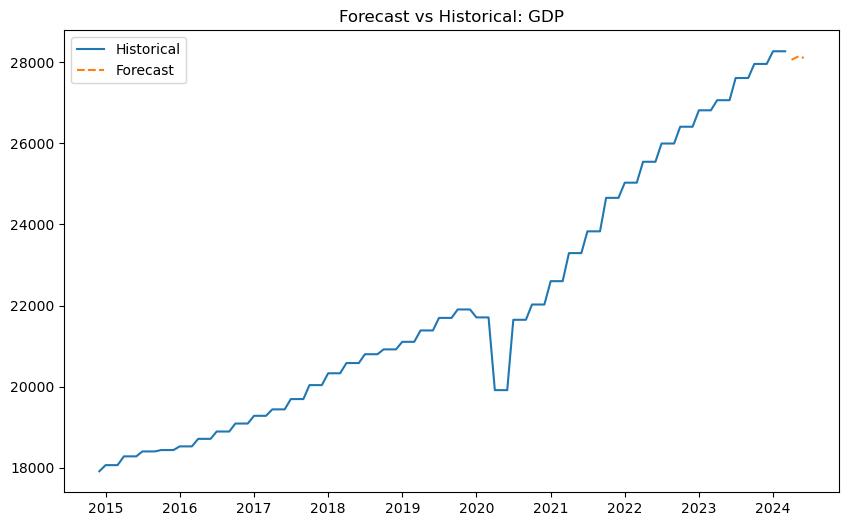

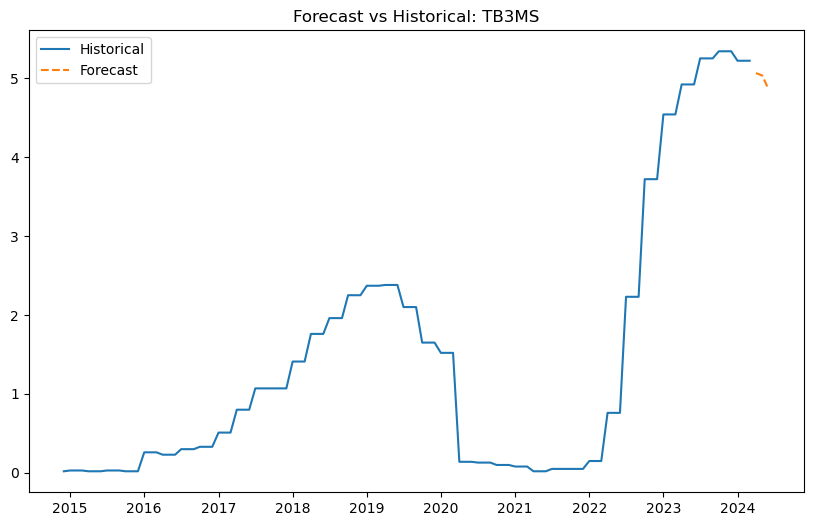

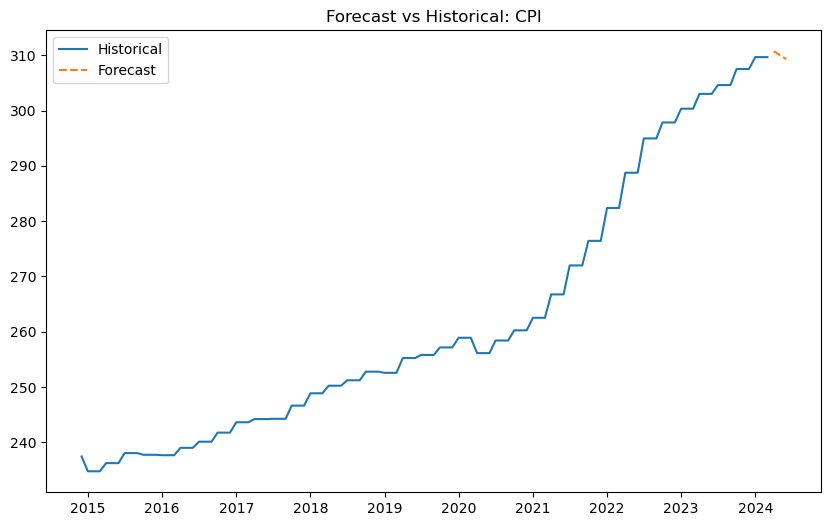

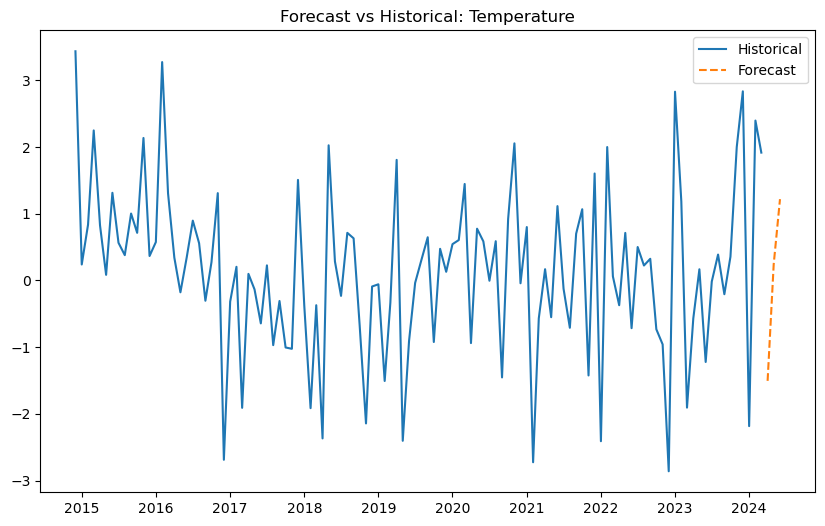

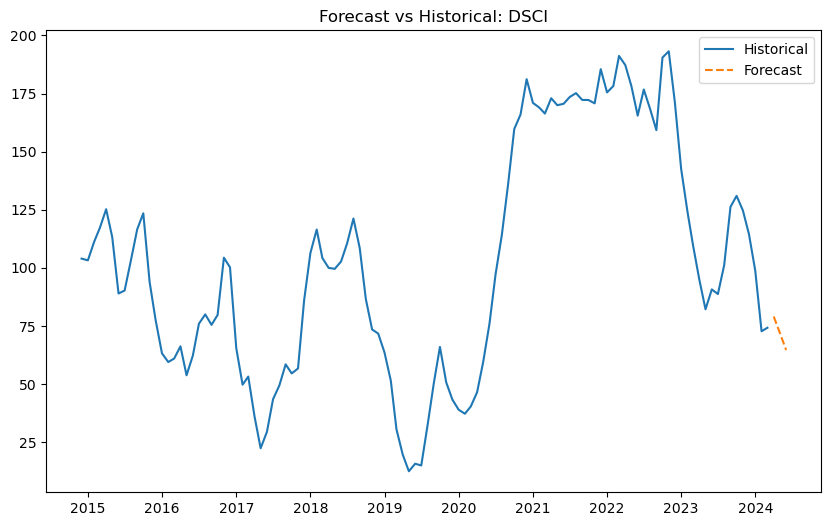

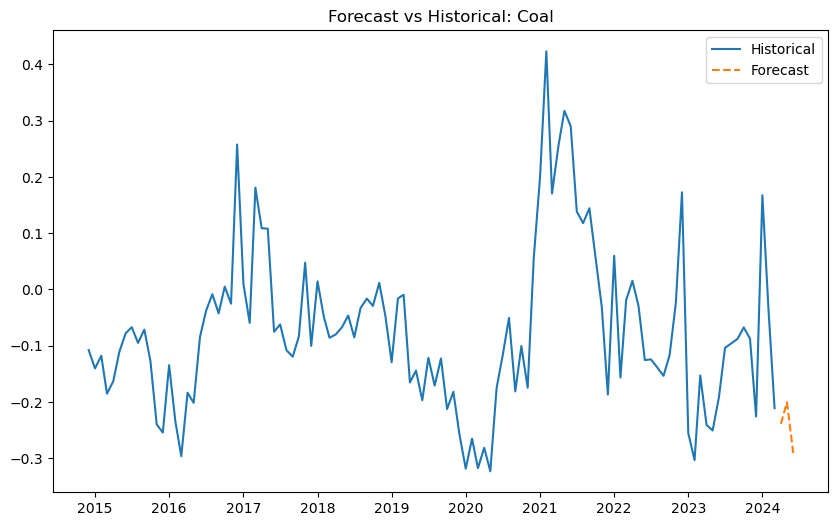

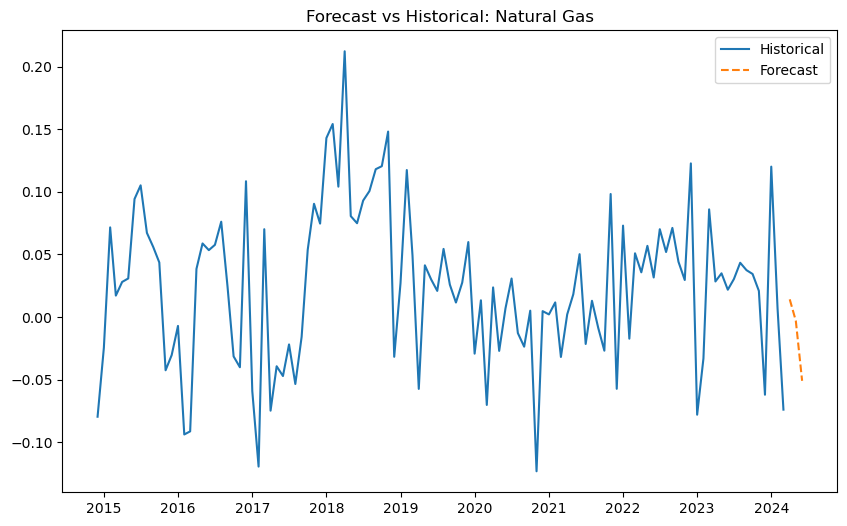

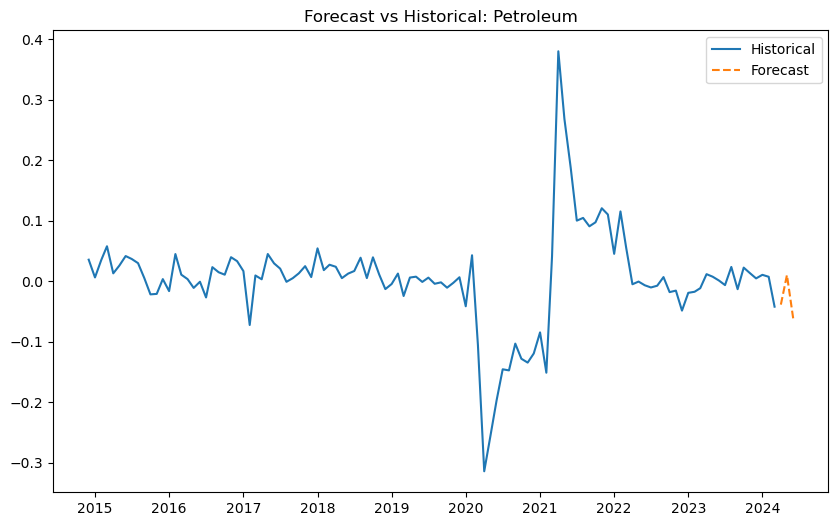

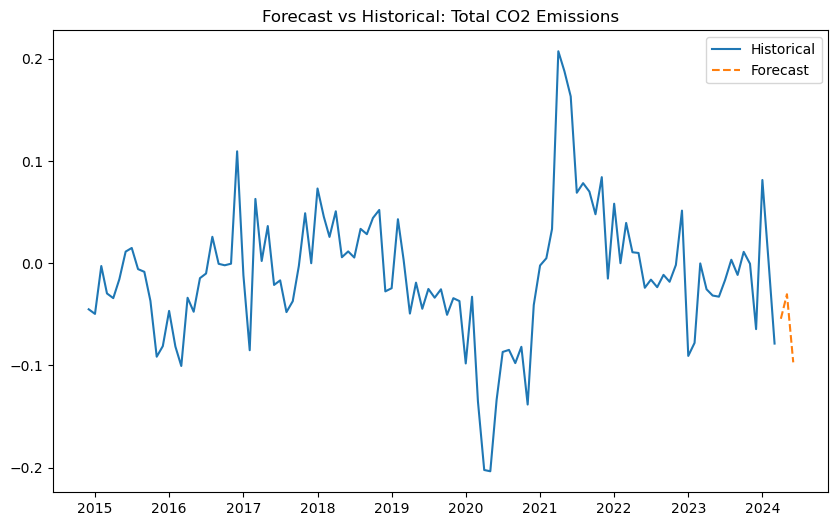

In [4]:
# Inicializar modelo
optimal_lags = optimize_lags(e_eco_data, trials=50)
vr_model = VR_Model(e_eco_data, optimal_lags)

# Ajustar el modelo y realizar predicciones
vr_model.fit()
vr_model.plot_predictions(steps=3)

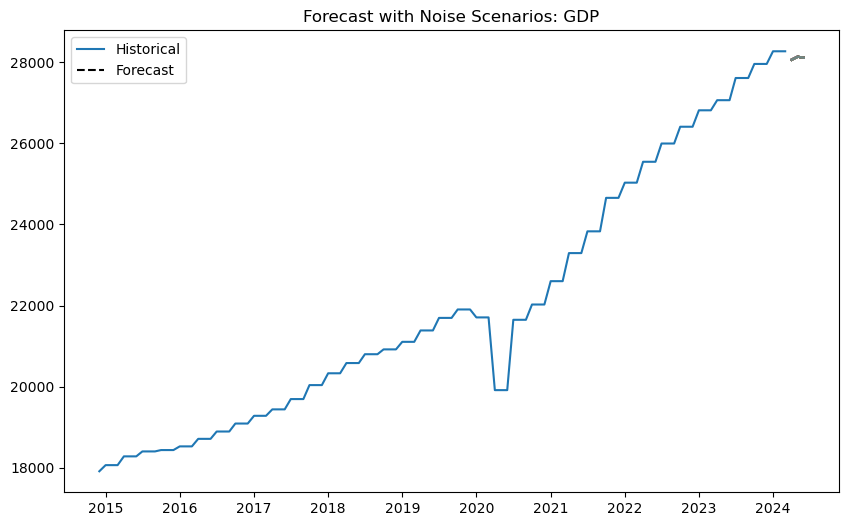

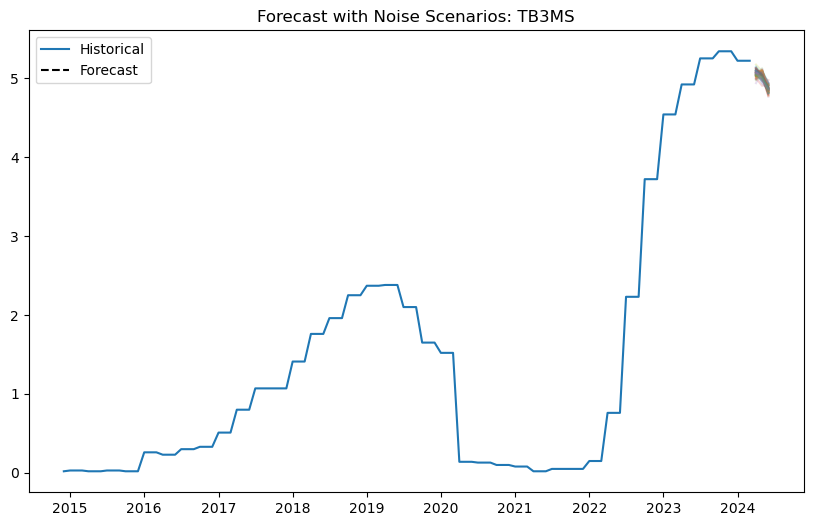

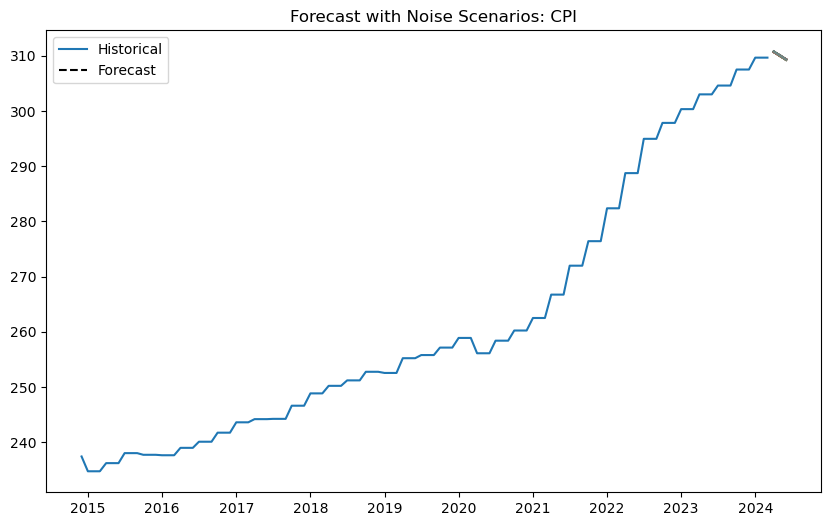

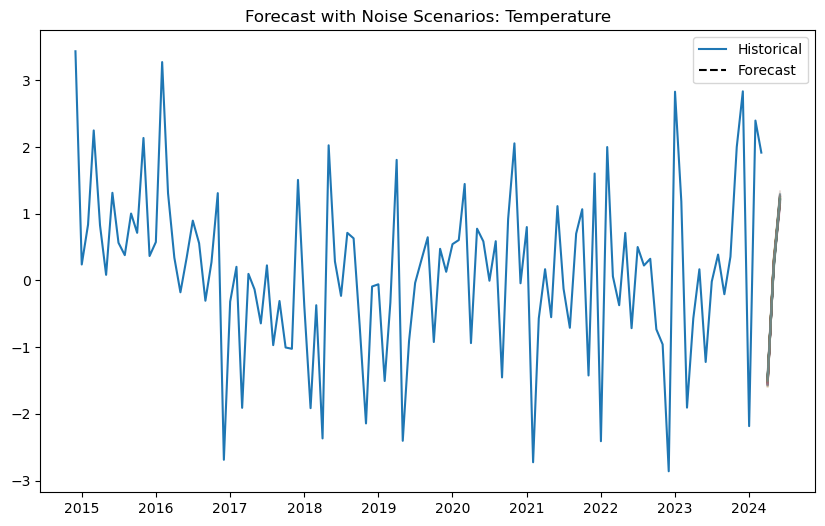

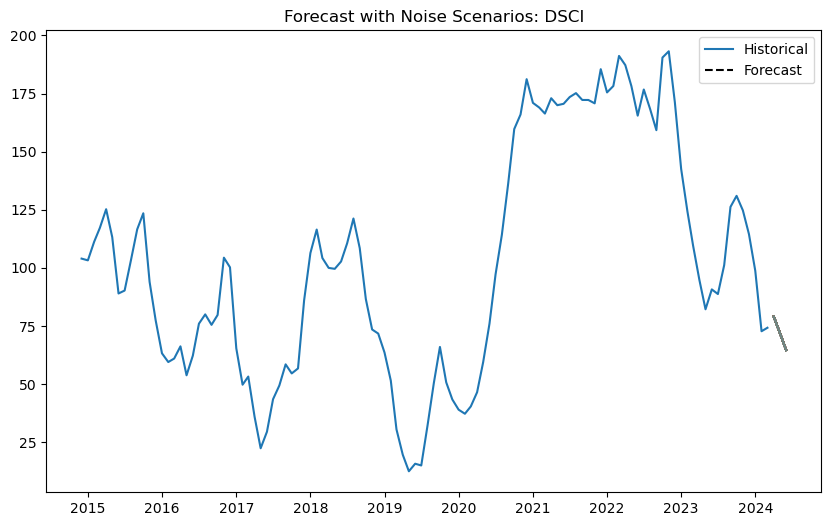

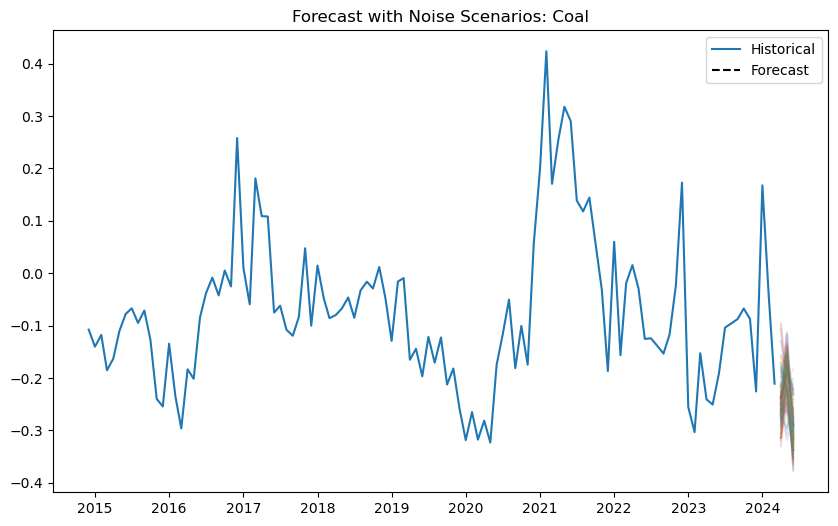

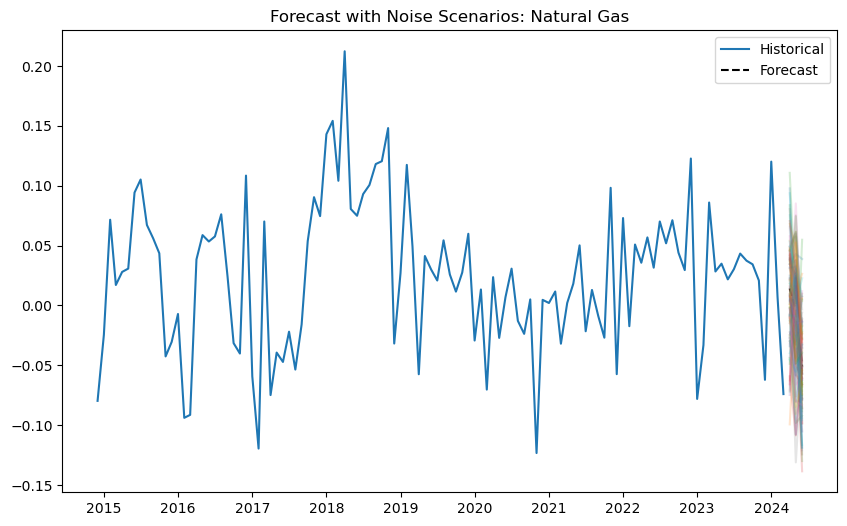

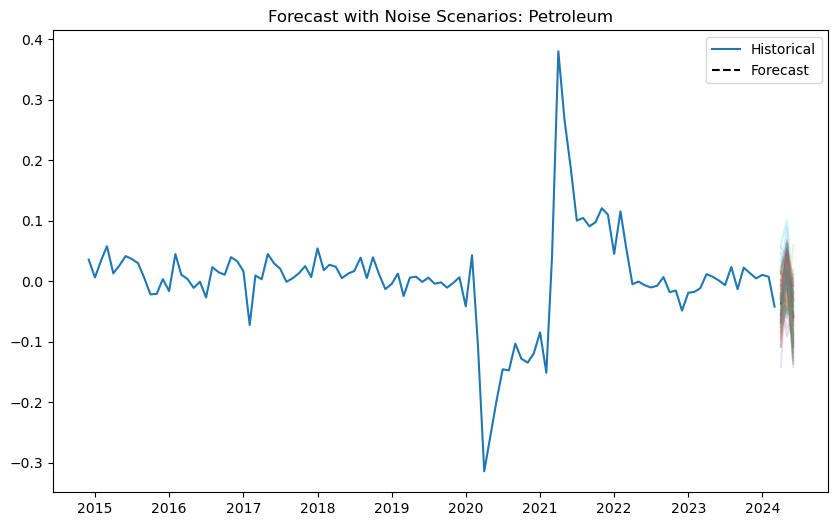

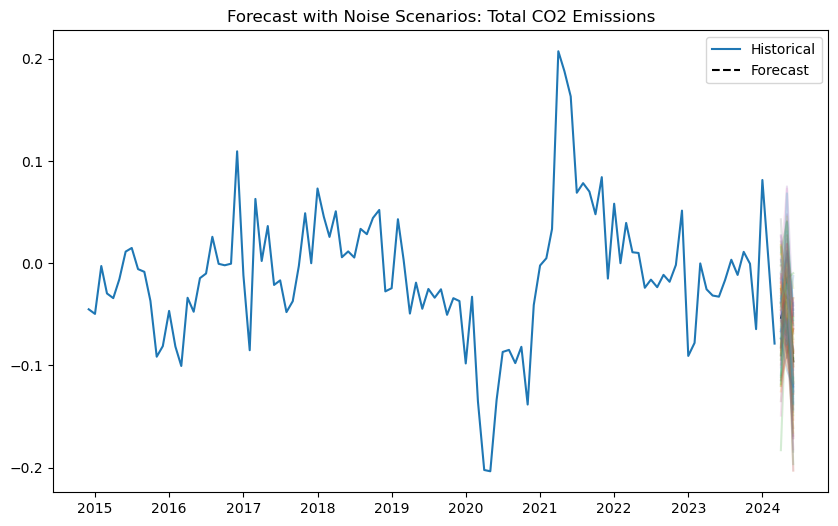

In [5]:
# Generar y graficar los escenarios con ruido
vr_model.generate_scenarios_with_noise(steps=3, n_scenarios=100)

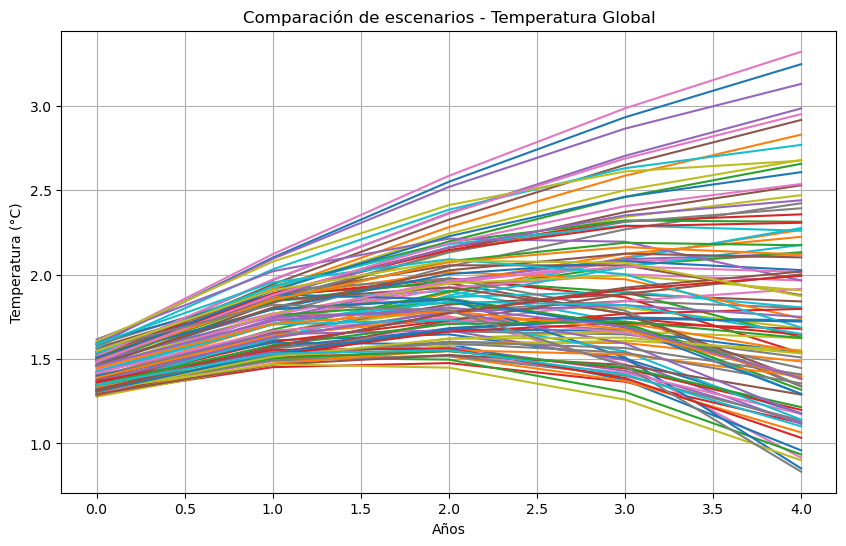

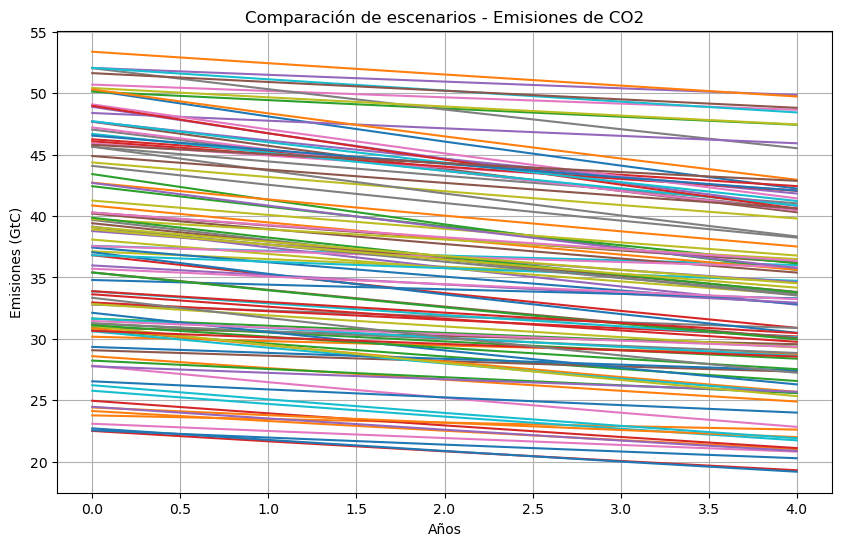

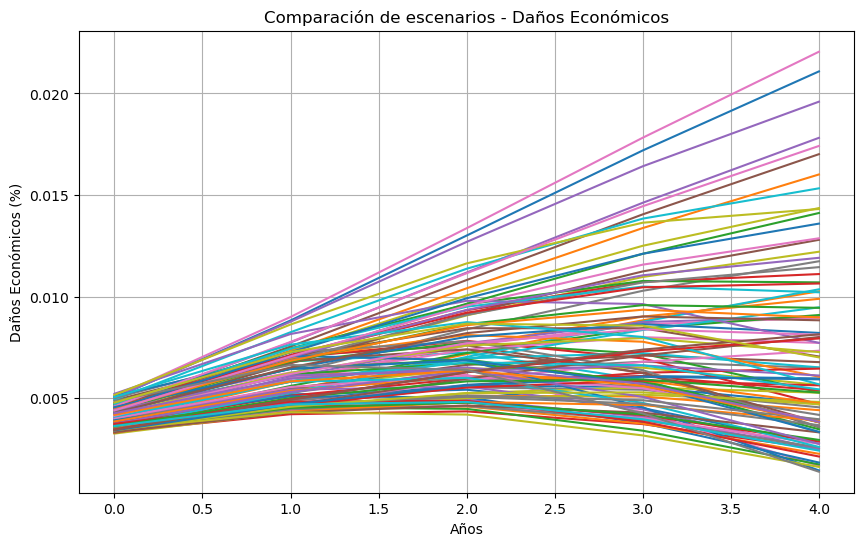

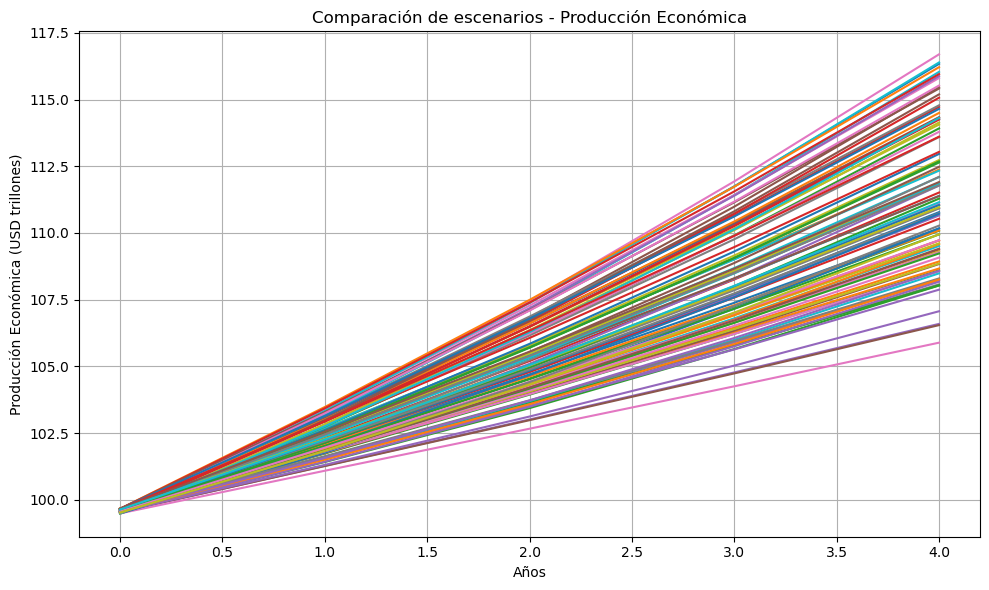

In [6]:
# Instanciar la clase ScenarioDICE
scenario_dice = ScenarioDICE()

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

In [7]:
economic_climate_vars = ['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum',
                         'Total CO2 Emissions', 'GDP', 'TB3MS', 'CPI']

aligned_data = all_data[economic_climate_vars].dropna()

aligned_data = aligned_data.loc[all_data.index]

# Inicializa un dataframe para almacenar las betas
betas_df = pd.DataFrame(index=gray_a + green_a, columns=economic_climate_vars)

# Calcula las betas de cada activo respecto a las demás variables
for asset in gray_a + green_a:
    # Prepara las variables dependientes e independientes
    X = aligned_data.values  # Variables económicas y climáticas
    y = all_data[asset].values  # Retornos del activo (ya están en all_data)

    # Ajusta un modelo de regresión lineal
    model = LinearRegression()
    model.fit(X, y)

    # Almacena las betas en el dataframe
    betas_df.loc[asset] = model.coef_

betas_df

Temperature      DSCI      Coal Natural Gas Petroleum  \
AAPL    0.008777 -0.000051 -0.442633    -0.56396 -1.031285   
IBM    -0.004645  0.000164  0.209145    0.137487  0.415654   
TSLA    0.025597 -0.000595 -0.850727    -0.97392 -2.026972   
GOOG    0.009861 -0.000205  0.371654    0.335359  0.408169   
TSM     0.013837  0.000023  0.015289   -0.237019 -0.555881   
NEE     0.000178 -0.000103 -0.299851   -0.380283  -0.54467   
FSLR      0.0218 -0.000015 -0.530892   -0.704204 -1.469721   
ENPH    0.003366 -0.000639 -1.086816   -1.025305 -2.140614   
BEP     0.003069  -0.00008 -0.290104   -0.409745 -0.624588   

     Total CO2 Emissions       GDP     TB3MS       CPI  
AAPL            1.926667  0.000017 -0.005865 -0.002418  
IBM            -0.954292  0.000003  0.008439 -0.000496  
TSLA            3.391758  0.000042 -0.044556 -0.003488  
GOOG           -1.184453   0.00001  0.001867 -0.001055  
TSM             0.423527   0.00003  0.011826 -0.004672  
NEE               1.1397  0.000023  -0.00609  -0.00316  
FSLR            2.635884 -0.000026 -0.013185  0.004077  
ENPH            3.745379  0.000135 -0.033183 -0.016856  
BEP             0.973063   0.00004 -0.004831 -0.005496

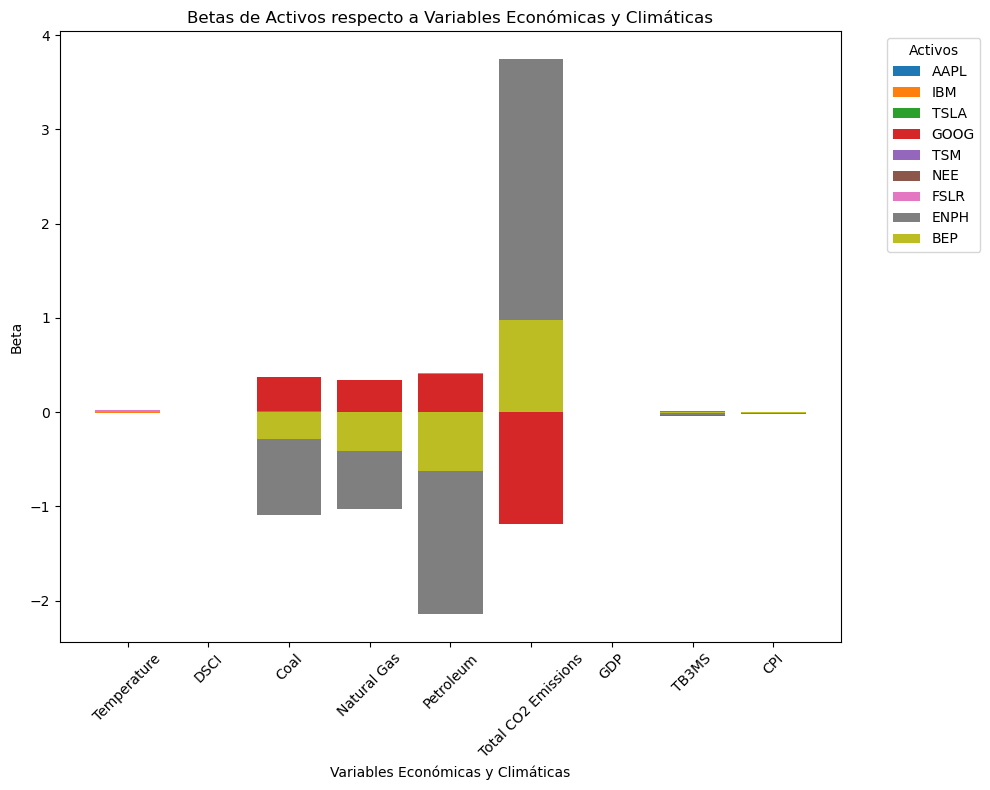

In [8]:
# Creamos una figura y subplots
fig, ax = plt.subplots(figsize=(10, 8))

# Para cada activo, graficamos las betas respecto a las variables
for asset in betas_df.index:
    ax.bar(betas_df.columns, betas_df.loc[asset], label=asset)

# Etiquetas y títulos
ax.set_title('Betas de Activos respecto a Variables Económicas y Climáticas')
ax.set_xlabel('Variables Económicas y Climáticas')
ax.set_ylabel('Beta')
ax.legend(title="Activos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotar etiquetas del eje x para mejor visibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: (9,)
Dimensiones de asset_prices: (114, 9)
Dimensiones de weights: 

                                              weights  metric_score strategy  \
0   [0.04, 0.02, 0.15, 0.02, 0.02, 0.02, 0.02, 0.6...     -0.206600   sharpe   
1   [0.01, 0.02, 0.03, 0.03, 0.01, 0.03, 0.15, 0.7...     -0.256162   sharpe   
2   [0.15, 0.06, 0.14, 0.01, 0.01, 0.04, 0.05, 0.5...     -0.271205   sharpe   
3   [0.03, 0.01, 0.16, 0.04, 0.18, 0.02, 0.08, 0.4...     -0.296540   sharpe   
4   [0.02, 0.07, 0.08, 0.03, 0.18, 0.03, 0.04, 0.5...     -0.308868   sharpe   
5   [0.04, 0.02, 0.02, 0.02, 0.15, 0.02, 0.02, 0.0...      1.989665    omega   
6   [0.17, 0.01, 0.11, 0.05, 0.18, 0.06, 0.03, 0.1...      2.497603    omega   
7   [0.1, 0.01, 0.09, 0.05, 0.18, 0.01, 0.03, 0.16...      2.493639    omega   
8   [0.11, 0.04, 0.07, 0.04, 0.14, 0.1, 0.08, 0.11...      2.464056    omega   
9   [0.08, 0.0, 0.08, 0.05, 0.13, 0.22, 0.11, 0.1,...      2.436434    omega   
10  [0.04, 0.02, 0.15, 0.02, 0.02, 0.02, 0.03, 0.5...     -0.309910  sortino   
11  [0.04, 0.0, 0.16, 0.03, 0.04, 0.05, 

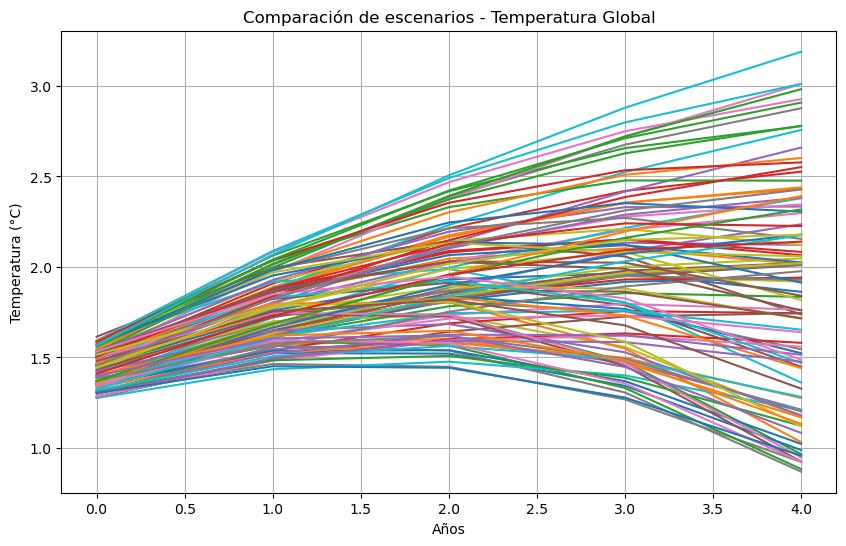

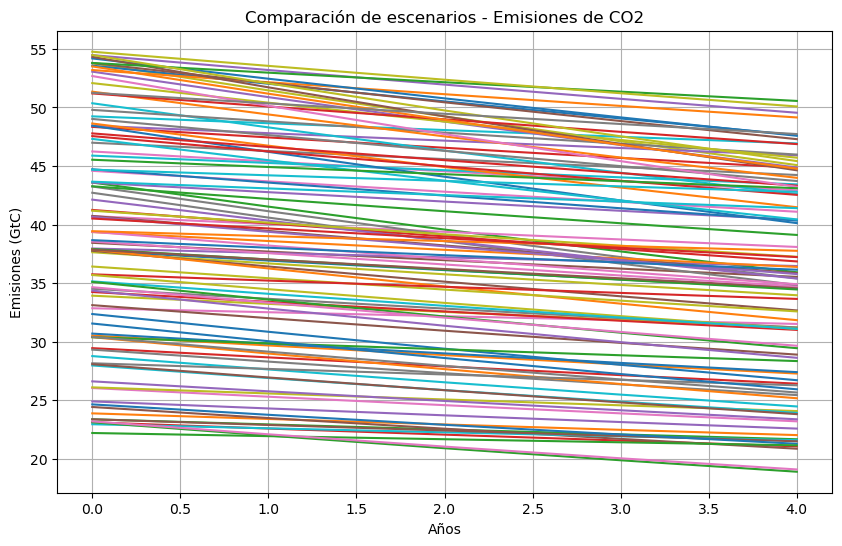

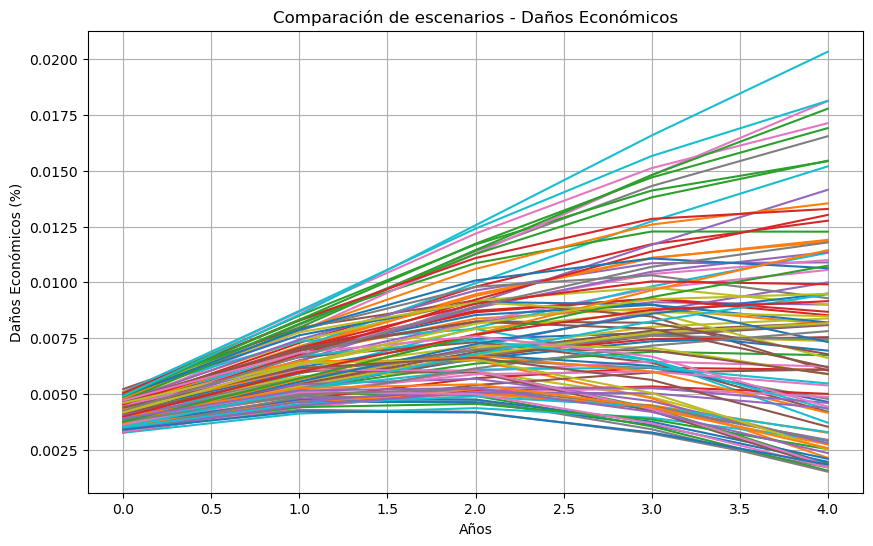

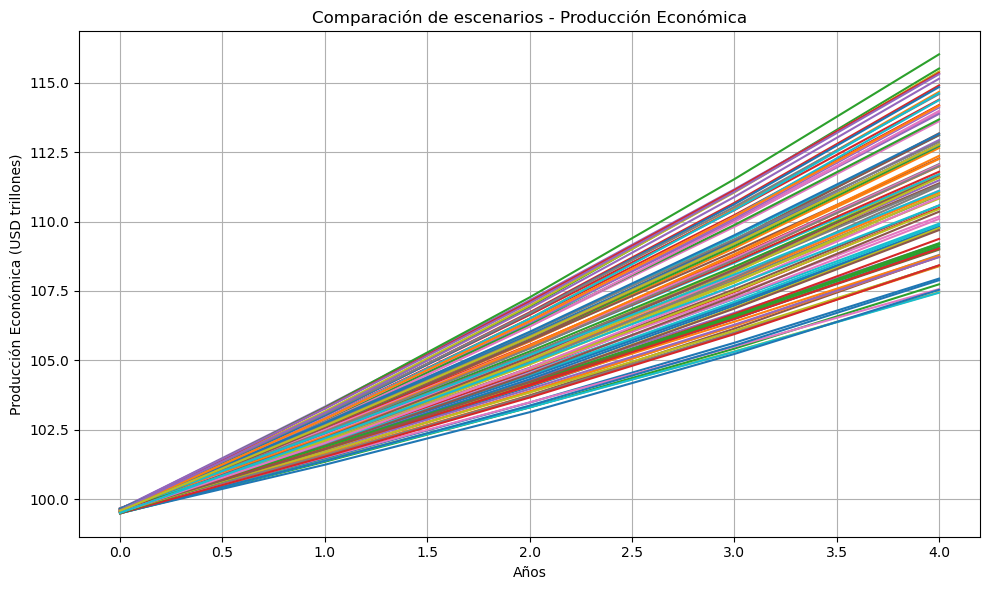


Retorno promedio del mejor portafolio: 266.2579


In [9]:
# Definir las variables económicas y climáticas
economic_factors = economic_data[['GDP', 'TB3MS', 'CPI']]  # Selecciona las columnas económicas que te interesan
climate_factors = climate_data[['Temperature', 'DSCI', 'Coal', 'Natural Gas', 'Petroleum', 'Total CO2 Emissions']]  # Selecciona las columnas climáticas

# Inicializar modelo VAR con los datos económicos y climáticos (e_eco_data)
optimal_lags = optimize_lags(e_eco_data, trials=50)
vr_model = VR_Model(e_eco_data, optimal_lags)

# Ajustar el modelo VAR
vr_model.fit()

# Obtener las predicciones del VAR para los próximos 3 periodos
var_predictions = vr_model.predict(steps=3)

# Inicializar optimizador de portafolios
optimizer = PortfolioOptimizer(
    asset_prices=asset_prices,
    risk_free_rate=rf,
    benchmark_prices=benchmark_prices,
    economic_factors=economic_factors,  # Datos económicos procesados
    climate_factors=climate_factors,    # Datos climáticos procesados
    betas=betas_df                      # Matriz de betas que has calculado
)

# Optimizar los portafolios con múltiples estrategias
optimal_portfolios, portfolios_df = optimizer.optimize_with_multiple_strategies(
    strategies=['sharpe', 'omega', 'sortino'],
    gray_assets=gray_a,
    green_assets=green_a
)

# Calcular los expected returns ajustados usando las predicciones del modelo VAR
portfolios_df = optimizer.calculate_portfolio_expected_returns(portfolios_df, var_predictions)

# Mostrar los portafolios con los expected returns calculados
print(portfolios_df)

# Generar 100 escenarios aleatorios
num_scenarios = 100
scenarios = scenario_dice.generate_random_scenarios(num_scenarios=num_scenarios)

years = 5
results = scenario_dice.simulate_multiple_scenarios(scenarios, years=years)
scenario_dice.plot_scenarios(results, years=years)

# Buscar el portafolio con el mejor score
best_portfolio = portfolios_df.loc[portfolios_df['expected_return'].idxmax()]

# Calcular el retorno promedio del mejor portafolio
average_return = np.mean(best_portfolio['expected_return'])

# Imprimir el mejor portafolio con su retorno promedio
print(f"\nRetorno promedio del mejor portafolio: {average_return:.4f}")


In [10]:
best_portfolio

weights            [0.0, 0.04, 0.32, 0.31, 0.2, 0.03, 0.01, 0.08,...
metric_score                                                -0.30512
strategy                                                     sortino
green_weight                                                     0.5
gray_weight                                                      0.5
expected_return                                           266.257879
Name: 28, dtype: object

In [11]:
# Descarga los datos financieros
downloader = DataDownloader()
gray_a = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'TSM']
green_a = ['NEE', 'FSLR', 'ENPH', 'BEP']
assets = gray_a + green_a
benchmark = '^GSPC'
start_date = '2024-06-01'
end_date = '2024-08-31'
rf = .065

backtesting_prices, benchmark_prices = downloader.get_prices(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets,
                                                          gray_a=gray_a,
                                                          green_a=green_a,
                                                          benchmark=benchmark)

backtesting_prices

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


Ticker            AAPL         IBM        TSLA        GOOG         TSM  \
Date                                                                     
2024-06-03  193.805664  163.846954  176.289993  173.992706  153.894684   
2024-06-04  194.125305  164.372360  174.770004  174.700958  151.431580   
2024-06-05  195.643539  165.928757  175.000000  176.636215  161.810394   
2024-06-06  194.255142  166.741638  177.940002  177.913086  160.966202   
2024-06-07  196.662369  168.535934  177.479996  175.518951  163.270401   
...                ...         ...         ...         ...         ...   
2024-08-26  227.179993  197.979996  213.210007  167.709229  168.448273   
2024-08-27  228.029999  198.729996  209.210007  166.161270  169.922821   
2024-08-28  226.490005  198.460007  205.750000  164.283737  168.577789   
2024-08-29  229.789993  198.899994  206.279999  163.185181  168.527969   
2024-08-30  229.000000  202.130005  214.110001  164.892944  171.068588   

Ticker            NEE        FSLR        ENPH        BEP  
Date                                                      
2024-06-03  77.209930  272.720001  127.550003  27.640715  
2024-06-04  76.653534  266.170013  129.770004  27.108404  
2024-06-05  76.554176  273.059998  133.240005  27.532282  
2024-06-06  76.206429  273.450012  132.300003  27.413990  
2024-06-07  74.904854  267.339996  122.750000  26.250792  
...               ...         ...         ...        ...  
2024-08-26  80.121071  233.190002  122.589996  24.653862  
2024-08-27  79.097702  235.419998  122.529999  24.693291  
2024-08-28  78.898994  228.570007  123.650002  24.693291  
2024-08-29  79.514999  223.100006  121.300003  24.575001  
2024-08-30  80.510002  227.369995  121.040001  24.490000  

[63 rows x 9 columns]

In [12]:
def calculate_portfolio_return(backtesting_prices, best_portfolio, initial_capital=1000000):
    # Extraer los precios iniciales y finales
    initial_prices = backtesting_prices.iloc[0]
    final_prices = backtesting_prices.iloc[-1]
    
    # Extraer los pesos del portafolio del diccionario best_portfolio
    weights = best_portfolio['weights']
    
    # Distribuir el capital inicial según los pesos
    capital_allocations = np.array(weights) * initial_capital
    
    # Calcular cuántas acciones se compran de cada activo
    shares_bought = capital_allocations / initial_prices
    
    # Calcular el valor final de cada posición (número de acciones * precio final)
    final_value = shares_bought * final_prices
    
    # Sumar el valor final de todas las posiciones para obtener el valor final del portafolio
    final_portfolio_value = final_value.sum()
    
    # Calcular el retorno total del portafolio
    portfolio_return = (final_portfolio_value / initial_capital) - 1
    
    return portfolio_return, final_portfolio_value

# Llamar a la función con los precios de backtesting y el portafolio
portfolio_return, final_portfolio_value = calculate_portfolio_return(backtesting_prices, best_portfolio)

print(f"El retorno final del portafolio es: {portfolio_return * 100:.2f}%")
print(f"El valor final del portafolio es: ${final_portfolio_value:.2f}")


El retorno final del portafolio es: 7.85%
El valor final del portafolio es: $1078499.10
